In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
import tensorflow.contrib.metrics as metrics
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.rnn as rnn


/Users/suvarnasundarakrishnan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.10.0'

In [3]:
random.seed(10000)

In [15]:
timeseriesrng=pd.date_range(start='2015',periods=1001,frequency='D')

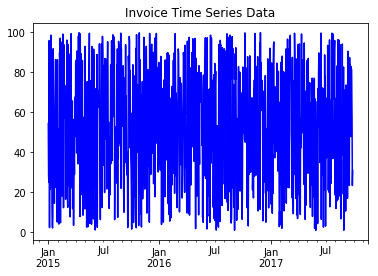

2015-01-01    54.414401
2015-01-02    28.004128
2015-01-03    25.105290
2015-01-04    95.843563
2015-01-05     2.437729
2015-01-06    81.367658
2015-01-07    21.492525
2015-01-08    22.827160
2015-01-09    42.981304
2015-01-10    98.528285
2015-01-11    90.653490
2015-01-12    79.564322
2015-01-13    14.160567
2015-01-14     3.760587
2015-01-15     2.232228
2015-01-16     8.225600
2015-01-17    91.713512
2015-01-18    41.019850
2015-01-19    26.645213
2015-01-20    54.008789
Freq: D, dtype: float64

In [16]:
timeseriesdata = pd.Series(np.random.uniform(1,100,size=len(timeseriesrng)),timeseriesrng)
timeseriesdata.plot(c='b',title = 'Invoice Time Series Data')
plt.show()
timeseriesdata.head(20)



In [17]:
TS = np.array(timeseriesdata)
num_periods = 20
f_horizon = 1
x_data  = TS[:(len(TS)-(len(TS) % num_periods))]
x_values = x_data.reshape(-1,20,1)
y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1,20,1)
print (len(x_values))
print (x_values.shape)
print (x_values[0:2])

print(y_batches[0:1])
print(y_batches.shape)

50
(50, 20, 1)
[[[54.41440057]
  [28.00412767]
  [25.10529021]
  [95.8435629 ]
  [ 2.43772861]
  [81.36765831]
  [21.4925253 ]
  [22.82716042]
  [42.98130378]
  [98.52828535]
  [90.65348969]
  [79.5643217 ]
  [14.16056747]
  [ 3.76058656]
  [ 2.23222843]
  [ 8.22559993]
  [91.71351173]
  [41.01984983]
  [26.64521288]
  [54.00878859]]

 [[14.61690241]
  [54.36224484]
  [66.4794828 ]
  [81.73903344]
  [86.32196619]
  [22.55189553]
  [50.82112326]
  [69.34984708]
  [28.83974575]
  [ 5.20202977]
  [86.30060006]
  [15.40892463]
  [51.54202843]
  [38.11695399]
  [ 4.27579277]
  [ 4.19293762]
  [37.12317598]
  [89.72720898]
  [85.78982897]
  [97.00374824]]]
[[[28.00412767]
  [25.10529021]
  [95.8435629 ]
  [ 2.43772861]
  [81.36765831]
  [21.4925253 ]
  [22.82716042]
  [42.98130378]
  [98.52828535]
  [90.65348969]
  [79.5643217 ]
  [14.16056747]
  [ 3.76058656]
  [ 2.23222843]
  [ 8.22559993]
  [91.71351173]
  [41.01984983]
  [26.64521288]
  [54.00878859]
  [14.61690241]]]
(50, 20, 1)


In [18]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX,testY
X_test,Y_test = test_data(TS,f_horizon,num_periods)
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[42.07330237]
  [28.96629951]
  [64.45877776]
  [17.02884988]
  [90.48906542]
  [86.7524265 ]
  [54.83348257]
  [55.84728024]
  [48.76542082]
  [23.51438597]
  [87.33278466]
  [76.59914985]
  [83.69788194]
  [58.17279728]
  [82.95110039]
  [47.87453831]
  [81.61998522]
  [67.74326085]
  [57.27484512]
  [23.42726913]]]


In [19]:

tf.reset_default_graph()
num_periods = 20
inputs =1
hidden =100
output = 1
X=tf.placeholder(tf.float32, [None,num_periods,inputs])
Y=tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation = tf.nn.relu)
rnn_output,states = tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)

learning_rate = 0.001
stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output,output)
outputs = tf.reshape(stacked_outputs, [-1,num_periods,output])

loss = tf.reduce_sum(tf.square(outputs-Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()


In [20]:
epochs = 10000
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {X:x_batches,Y: y_batches})
        if ep%100 ==0:
                mse = loss.eval(feed_dict={X:x_batches,Y:y_batches})
                print(ep, "\MSE:",mse)
    y_pred = sess.run(outputs,feed_dict={X: X_test})
    print(y_pred)

0 \MSE: 3163409.5
100 \MSE: 926290.6
200 \MSE: 843060.0
300 \MSE: 830078.5
400 \MSE: 723387.1
500 \MSE: 691805.9
600 \MSE: 503585.84
700 \MSE: 538048.56
800 \MSE: 402895.03
900 \MSE: 489837.44
1000 \MSE: 322854.75
1100 \MSE: 300481.4
1200 \MSE: 302165.8
1300 \MSE: 272345.22
1400 \MSE: 255578.23
1500 \MSE: 247432.67
1600 \MSE: 287557.94
1700 \MSE: 227484.31
1800 \MSE: 219069.38
1900 \MSE: 221640.34
2000 \MSE: 212559.94
2100 \MSE: 204958.6
2200 \MSE: 197031.05
2300 \MSE: 195585.75
2400 \MSE: 189335.62
2500 \MSE: 184299.02
2600 \MSE: 241531.94
2700 \MSE: 176802.47
2800 \MSE: 172910.12
2900 \MSE: 172813.84
3000 \MSE: 164462.86
3100 \MSE: 172689.98
3200 \MSE: 162325.62
3300 \MSE: 158361.12
3400 \MSE: 156298.31
3500 \MSE: 151356.62
3600 \MSE: 148134.47
3700 \MSE: 144958.17
3800 \MSE: 142828.83
3900 \MSE: 139680.97
4000 \MSE: 153253.78
4100 \MSE: 134980.95
4200 \MSE: 132203.48
4300 \MSE: 129744.07
4400 \MSE: 127265.58
4500 \MSE: 124753.266
4600 \MSE: 133797.06
4700 \MSE: 125051.516
4800 \MSE:

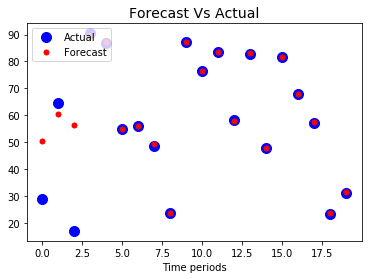

In [21]:
plt.title("Forecast Vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)),"bo",markersize = 10, label = "Actual")
#plt.plot(pd.Series(np.ravel(Y_test)),"w*",markersize = 10)

plt.plot(pd.Series(np.ravel(y_pred)),"r.",markersize = 10, label = "Forecast")
plt.legend(loc= "upper left")
plt.xlabel("Time periods")
plt.show()

In [22]:
fcst=pd.Series(np.ravel(y_pred))
act=pd.Series(np.ravel(Y_test))

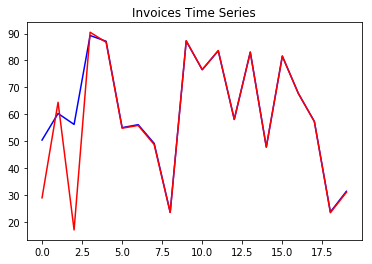

In [23]:

fcst.plot(c='b',title = 'Invoices Time Series')
act.plot(c='r')

plt.show()
sess.close()